In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.3 MB/s eta 0:00:00


# Chargement des données:

In [2]:
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from cv2 import imread , cvtColor, COLOR_BGR2RGB, resize
import torchvision.transforms as transforms
from torch import from_numpy
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
import  matplotlib.pyplot as plt

In [3]:
def Lecture_fichier_annotations(path_annotations):
  relations = []
  data = json.load(open(path_annotations))
  for img in data:
    for annot in img["annotations"]:
        annot["url"] = img["url"]
        annot["width"] = img["width"]
        annot["height"] = img["height"]
        relations.append(annot)
  return relations


In [4]:
def Plot_image(path,nom_fi, nom_fi_anno):
  dic_annotation_images = Lecture_fichier_annotations(nom_fi_anno)
  l_url = [dic_annotation_images[i]["url"].split('/')[-1] for i in range(len(dic_annotation_images))]
  index = l_url.index(nom_fi)
  dic_annotation_image =  dic_annotation_images[index]


  img = Image.open( os.path.join(path , nom_fi))
  vis = Image.new("RGB",(img.size[0], img.size[1]+50), color="white")

  vis.paste(img)

  draw = ImageDraw.Draw(vis)
  #fnt = ImageFont.truetype("arial", size=25)
  fnt = ImageFont.load_default()
  s = "%s-%s-%s    %s" % (
      dic_annotation_image["subject"]["name"],
      dic_annotation_image["predicate"],
     dic_annotation_image["object"]["name"],
      str(dic_annotation_image["label"]),
  )
  #draw.text((40, dic_annotation_image["height"]), s, font=fnt, fill="black")

  y0, y1, x0, x1 = dic_annotation_image["subject"]["bbox"]
  draw.rectangle([x0, y0, x1, y1], outline="red", width=3)
  y0, y1, x0, x1 = dic_annotation_image["object"]["bbox"]
  draw.rectangle([x0, y0, x1, y1], outline="blue", width=3)
  plt.imshow(vis)
  #plt.title(s)
  plt.title(  dic_annotation_image["subject"]["name"],loc = 'left',color='red')
  plt.title( dic_annotation_image["object"]["name"], color='blue')
  plt.title( dic_annotation_image["predicate"] + ' ' + str(dic_annotation_image["label"]), color='black',loc = 'right')
  #plt.title( str(dic_annotation_image["label"]), color='black')
  #plt.show()

  plt.show()



In [ ]:

Plot_image('/content/gdrive/MyDrive/Colab Notebooks/projetM2/data/images/flickr/'
    ,'10016057385_47fa233771.jpg','annotations.json')

In [5]:
from keras.applications.vgg16 import preprocess_input
import matplotlib.patches as patches

In [6]:
import os
def images_rep(chemin_repertoire):
  return  os.listdir(chemin_repertoire)

In [7]:
def segmentation(image,   Bbox1,  Bbox2):
    image_segm = np.zeros((np.shape(image)[0],np.shape(image)[1],np.shape(image)[2]), dtype='uint8')
    x11,y11,x12,y12 = [Bbox1[2],Bbox1[0] ,Bbox1[3], Bbox1[1]]
    x21,y21,x22,y22 = [Bbox2[2],Bbox2[0] ,Bbox2[3], Bbox2[1]]

    image_segm[y11:y12, x11:x12, :]= np.full((abs(y11-y12), abs(x11-x12),3), 255, dtype='uint8') #image[y11:y12, x11:x12,:]
    image_segm[y21:y22, x21:x22, :]= np.full((abs(y21-y22), abs(x21-x22),3), 155, dtype='uint8') #image[y21:y22, x21:x22, :]

    return image_segm, [x11,y11,x12,y12], [ x21,y21,x22,y22]




In [8]:
def Crop(image,Bbox1,Bbox2):

    bbox1 = [Bbox1[2],Bbox1[0] ,Bbox1[3], Bbox1[1]]
    bbox2 = [Bbox2[2],Bbox2[0] ,Bbox2[3], Bbox2[1]]
    x_min = min(bbox1[0], bbox2[0])
    y_min = min(bbox1[1], bbox2[1])
    x_max = max(bbox1[2], bbox2[2])
    y_max = max(bbox1[3], bbox2[3])

    # Rogner l'image
    return image[y_min:y_max, x_min:x_max], bbox1,bbox2


In [9]:
def do_bboxes_overlap(bbox1, bbox2):

    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2

    # Vérifier si les boîtes se chevauchent sur l'axe X
    overlap_x = x1_1 < x2_2 and x2_1 > x1_2

    # Vérifier si les boîtes se chevauchent sur l'axe Y
    overlap_y = y1_1 < y2_2 and y2_1 > y1_2

    # Si les boîtes se chevauchent sur les deux axes, elles partagent une région
    return overlap_x and overlap_y

In [10]:
def BBOX_c(Bbox1,Bbox2):
  bounding_boxes = np.zeros((len(Bbox1),16), dtype = np.int32)
  for i in range(len(bounding_boxes )):
    x11,y11,x12,y12 = [Bbox1[i][2],Bbox1[i][0] ,Bbox1[i][3], Bbox1[i][1]]
    x21,y21,x22,y22 = [Bbox2[i][2],Bbox2[i][0] ,Bbox2[i][3], Bbox2[i][1]]
    bounding_boxes[i,:] = np.array([x11,y11,  x12,y11, x12, y12, x11,y12,x21 , y21,x22, y21 ,x22, y22,x21, y22] ,dtype = np.int32)#np.array([y11,x11, y11, x12,y12,x12,y12,x11, y21,x21,y21,x22,y22,x22,y22,x21] ,dtype = np.int32)

  return bounding_boxes

In [11]:
def chargement_data(path, nom_fi_anno, n):

    dic_annotation_images = np.array(Lecture_fichier_annotations(nom_fi_anno))


    l_url = np.array([dic_annotation_images[i]["url"].split('/')[-1] for i in range
     (len(dic_annotation_images))][0:n])
    l_annotation =  np.array([dic_annotation_images[i]["predicate"] for i in
                              range(len(dic_annotation_images))][0:n])
    l_bbox1 = np.array([dic_annotation_images[i]["subject"]["bbox"] for i in
                              range(len(dic_annotation_images))][0:n])
    l_bbox2 = np.array([dic_annotation_images[i]["object"]["bbox"] for i in
                              range(len(dic_annotation_images))][0:n])
    l_label =  np.array([dic_annotation_images[i]["label"] for i in
                              range(len(dic_annotation_images))][0:n])

    l_nom_subject = np.array([dic_annotation_images[i]["subject"]["name"] for i in
                              range(len(dic_annotation_images))][0:n])
    l_nom_object = np.array([dic_annotation_images[i]["object"]["name"] for i in
                              range(len(dic_annotation_images))][0:n])




    Anotation_5_C =np.where((( l_annotation == 'to the left of') |
    ( l_annotation == 'under')  |
      ( l_annotation == 'to the right of')  | ( l_annotation == 'above') ) & l_label == True)[0]

    l_ind= []
    for v in Anotation_5_C :
      if  (  do_bboxes_overlap( [  l_bbox1[v][2], l_bbox1[v][0] , l_bbox1[v][3],l_bbox1[v][1]] , [l_bbox2[v][2],l_bbox2[v][0] ,l_bbox2[v][3], l_bbox2[v][1]]) == False):
        l_ind.append(v)

    l_url_5C = l_url[np.array(l_ind)]
    l_anno_5C = l_annotation [np.array(l_ind)]
    l_bbox5C_1 = l_bbox1[np.array(l_ind)]
    l_bbox5C_2 = l_bbox2[np.array(l_ind)]
    lab = l_label[np.array(l_ind)]
    l_nom_sub =  l_nom_subject[np.array(l_ind)]
    l_nom_obj =  l_nom_object[np.array(l_ind)]
    l_descripteurs = np.array([l_nom_sub[i] + ' ' + l_anno_5C [i]+ ' ' +  l_nom_obj[i] for i in range(len( l_nom_obj))])








    min_occ_c = np.min(np.unique(   l_anno_5C, return_counts=True)[1])


    url_C1 =  l_url_5C[ l_anno_5C == 'to the left of'][: min_occ_c]
    url_C3 =  l_url_5C[ l_anno_5C == 'under'  ][: min_occ_c]
    url_C4 =  l_url_5C[ l_anno_5C == 'to the right of'  ][: min_occ_c]
    url_C5 =  l_url_5C[ l_anno_5C == 'above'  ][: min_occ_c]

    l_url_cs = np.concatenate((url_C1,url_C3  ,url_C4 ,url_C5 ), axis=0)#    url_C2


    l_anno_c =    np.concatenate((np.array(['to the left of'] *  min_occ_c),
                                np.array(['under' ] *  min_occ_c),
                               np.array(['to the right of'] *  min_occ_c),
                                np.array(['above'] *  min_occ_c) ), axis=0)



    liste_lab = np.concatenate((lab[ l_anno_5C == 'to the left of'][: min_occ_c],
                               lab [ l_anno_5C == 'under'  ][: min_occ_c] ,
                                lab[ l_anno_5C == 'to the right of'  ][: min_occ_c]
                              , lab[ l_anno_5C == 'above'  ][: min_occ_c] ), axis=0)





    l_bbox_1_C1 =  l_bbox5C_1[ l_anno_5C == 'to the left of'][: min_occ_c]
    l_bbox_1_C3  =  l_bbox5C_1[ l_anno_5C == 'under'  ][: min_occ_c]
    l_bbox_1_C4  =  l_bbox5C_1[ l_anno_5C == 'to the right of'  ][: min_occ_c]
    l_bbox_1_C5  =  l_bbox5C_1[ l_anno_5C == 'above'  ][: min_occ_c]
    l_bbox_1_5Cs = np.concatenate((l_bbox_1_C1,l_bbox_1_C3, l_bbox_1_C4, l_bbox_1_C5 ), axis=0)#, l_bbox_1_C2


    l_bbox_2_C1 =  l_bbox5C_2[ l_anno_5C == 'to the left of'][: min_occ_c]
    l_bbox_2_C3  =  l_bbox5C_2[ l_anno_5C == 'under'  ][: min_occ_c]
    l_bbox_2_C4  =  l_bbox5C_2[ l_anno_5C == 'to the right of'  ][: min_occ_c]
    l_bbox_2_C5  =  l_bbox5C_2[ l_anno_5C == 'above'  ][: min_occ_c]
    l_bbox_2_5Cs = np.concatenate((l_bbox_2_C1,l_bbox_2_C3, l_bbox_2_C4, l_bbox_2_C5 ), axis=0)



    l_d_C1 =  l_descripteurs[ l_anno_5C == 'to the left of'][: min_occ_c]
    l_d_C3  =  l_descripteurs[ l_anno_5C == 'under'  ][: min_occ_c]
    l_d_C4  =  l_descripteurs[ l_anno_5C == 'to the right of'  ][: min_occ_c]
    l_d_C5  =  l_descripteurs[ l_anno_5C == 'above'  ][: min_occ_c]
    l_d_5Cs = np.concatenate((l_d_C1,l_d_C3, l_d_C4, l_d_C5 ), axis=0)

    l_path = []
    l_anno = []
    L_bbox_1 = []
    L_bbox_2 = []
    llab = []
    l_text_description = []



    for k in range(len(l_anno_c)) :

      if l_url_cs[k] in images_rep(os.path.join(path ,'nyu/')):


        l_path.append(os.path.join(path ,'nyu/',l_url_cs [k]))
        l_anno.append( l_anno_c[k])
        L_bbox_1.append(l_bbox_1_5Cs[k])
        L_bbox_2.append(l_bbox_2_5Cs[k])
        llab.append(liste_lab[k])
        l_text_description.append( l_d_5Cs[k])

      else:
        if l_url_cs [k] in images_rep(os.path.join(path ,'flickr/')):

          l_path.append(os.path.join(path ,'flickr/',l_url_cs [k]))
          l_anno.append( l_anno_c[k])
          L_bbox_1.append(l_bbox_1_5Cs[k])
          L_bbox_2.append(l_bbox_2_5Cs[k])
          llab.append(liste_lab[k])
          l_text_description.append( l_d_5Cs[k])







    masques_ss = np.zeros((len(l_path),224,224,3), dtype=int)
    images_rgb = np.zeros((len(l_path),224,224,3), dtype=int)


    for e in range(len(l_path)):


      masque = segmentation(imread(l_path[e]) , L_bbox_1[e],  L_bbox_2[e])
      #plot_with_bboxs(l_path[e], image_crop[1],image_crop[2])
      masques_ss[e,:,:,:]  = resize(masque[0], (224,224), interpolation=cv2.INTER_NEAREST)
      images_rgb[e,:,:,:]  = cvtColor( resize(imread(l_path[e]), (224,224)) ,  COLOR_BGR2RGB)





    # melanger la matrice d'image et de label:
    idx = np.random.permutation(len(  images_rgb))
    images_5C_alea = images_rgb[idx]
    masques_alea = masques_ss[idx]
    label_5C_alea =  np.array(l_anno)[idx]
    l_text_d_alea = np.array(l_text_description)[idx]


    # Encodage des label
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(label_5C_alea)



    return   images_5C_alea , masques_alea , integer_encoded, l_text_d_alea
    #print(np.shape( images_rgb))

In [12]:
from cv2 import imread , cvtColor, COLOR_BGR2RGB, resize, findContours, boundingRect,RETR_EXTERNAL, CHAIN_APPROX_SIMPLE, COLOR_BGR2GRAY, rectangle
from itertools import combinations

In [13]:
def aire_bbox(x1, y1, x2, y2):
    # Calcule l'aire d'une bbox à partir de ses coordonnées
    largeur = abs(x2 - x1)
    hauteur = abs(y2 - y1)
    return largeur * hauteur

def bbox_plus_petite(bbox1, bbox2):
    # Calcule l'aire des deux bbox
    aire_bbox1 = aire_bbox(*bbox1)
    aire_bbox2 = aire_bbox(*bbox2)

    # Renvoie la bbox avec la plus petite aire
    if aire_bbox1 < aire_bbox2:
        return bbox1
    else:
        return bbox2

In [14]:
def pplot(bounding_boxes_ima, image):

  for box in bounding_boxes_ima:
      # Décompressez les coordonnées de la boîte englobante
      x, y, x_plus_w, y_plus_h = box
      rectangle(image, (x, y), (x_plus_w, y_plus_h), (255, 0, 0), 2)

  # Affichez l'image avec les boîtes englobantes
  plt.imshow( image)
  plt.show()

In [15]:
def plot_with_bboxs(image, image_crop1, image_crop2):
      fig, ax = plt.subplots(1, 1)
      ax.imshow( imread(image) )

      rect1 = patches.Rectangle((image_crop1[0], image_crop1[1]), image_crop1[2] -image_crop1[0],
                      image_crop1[3] - image_crop1[1],   linewidth=1, edgecolor='r', facecolor='none')
      rect2 = patches.Rectangle((image_crop2[0], image_crop2[1]), image_crop2[2] -image_crop2[0],
                      image_crop2[3] - image_crop2[1],   linewidth=1, edgecolor='b', facecolor='none')

      ax.add_patch(rect1)
      ax.add_patch(rect2)
      plt.show()

In [16]:
def Bbox(ims, labels):


  #bounding_boxes = np.zeros((len(ims),2,2,2), dtype = np.int32)
  bounding_boxes = np.zeros((len(ims),16), dtype = np.int32)

  for i in range(len(ims)):


    image_gris =cvtColor(ims[i], COLOR_BGR2GRAY)

    #image_gris[image_gris == image_gris[0][0]] = 0
    mask_obj1 = np.where(image_gris== np.unique(image_gris)[1], 255, 0).astype('uint8')
    mask_obj2 = np.where(image_gris== np.unique(image_gris)[2], 255, 0).astype('uint8')
    contours1, _ = findContours(mask_obj1, RETR_EXTERNAL, CHAIN_APPROX_SIMPLE)
    contours2, _ = findContours(mask_obj2, RETR_EXTERNAL, CHAIN_APPROX_SIMPLE)
    c = [contours1, contours2]




    for k in range(len(c)):
      contours = c[k]
      bounding_boxes_ima = []
      for e in range(len(contours)):
        x, y, w, h = boundingRect(contours[e])

        bounding_boxes_ima.append([x, y, x + w, y + h])



      if len(bounding_boxes_ima) ==2:
        comb= list(combinations(bounding_boxes_ima, 2))

        indx = [do_bboxes_overlap(comb[j][0], comb[j][1]) for j in range(len(comb))].index(True)

        bbox_p = bbox_plus_petite(comb[indx][0],comb[indx][1])

        bounding_boxes_ima.remove( bbox_p )



        bounding_boxes[i,k*8:(k+1)*8] = np.array( [  bounding_boxes_ima[0][1],bounding_boxes_ima[0][0],
                                          bounding_boxes_ima[0][1], bounding_boxes_ima[0][2],

                                          bounding_boxes_ima[0][3],bounding_boxes_ima[0][2],
                                          bounding_boxes_ima[0][3],  bounding_boxes_ima[0][0]], dtype=np.int32)


      else:

        bounding_boxes[i,k*8:(k+1)*8] = np.array( [  bounding_boxes_ima[0][1],bounding_boxes_ima[0][0],
                                          bounding_boxes_ima[0][1], bounding_boxes_ima[0][2],

                                        bounding_boxes_ima[0][3], bounding_boxes_ima[0][2],
                                          bounding_boxes_ima[0][3] ,bounding_boxes_ima[0][0] ], dtype=np.int32)




  bounding_boxes1 = np.zeros((len(ims),16), dtype = np.int32)


  return bounding_boxes, labels.astype('int32')

#Split:

In [18]:
def split_data(x_data, y_data, size):
  # Diviser les données en ensembles d'entraînement et de test
  return train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

In [19]:
def Split_Images_bbox(images, bboxs, labels, size):
  return  train_test_split(images, bboxs, labels, test_size=size, random_state=42)

#Modele:

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [21]:
def Modele(n_classe,fine_tune):
  # Chargement de VGGNet sans sa partie de classification
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  #----    Raffinement du modèle pré-entraîné ---------:


  # Geler les couches du modèle pré-entraîné
  for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False





  x = base_model.output # Vecteur des caractéristiques
  #print('dimension de sortie: ',base_model.output.shape)
  x = Flatten()(x)  # Convertit les caractéristiques 3D en vecteur 1D
  #print('dimension de sortie apres convertion en un vecteur 1 d',x.shape)
  # Ajouter la première couche FC (FC-0)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu', name='FC-0',  kernel_regularizer=l2(0.01))(x)

  # Ajouter la deuxième couche FC (FC-1)
  x = Dense(256, activation='relu', name='FC-1', kernel_regularizer=l1(0.01))(x)
  x = Dropout(0.3)(x)

  # Ajouter la couche de sortie pour la classification

  predictions = Dense(n_classe, activation='sigmoid', name='predictions')(x)  # pour les n classes:

  model = Model(inputs=base_model.input, outputs=predictions)
  return model

In [ ]:
def Modele(n_classe,fine_tune):
  # Chargement de VGGNet sans sa partie de classification
  base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
  #----    Raffinement du modèle pré-entraîné ---------:


  # Geler les couches du modèle pré-entraîné
  for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False





  x = base_model.output # Vecteur des caractéristiques
  #print('dimension de sortie: ',base_model.output.shape)
  x = Flatten()(x)  # Convertit les caractéristiques 3D en vecteur 1D
  #print('dimension de sortie apres convertion en un vecteur 1 d',x.shape)
  # Ajouter la première couche FC (FC-0)

  x = Dense(512, activation='relu', name='FC-0')(x)

  # Ajouter la deuxième couche FC (FC-1)
  x = Dense(256, activation='relu', name='FC-1')(x)


  # Ajouter la couche de sortie pour la classification
  #predictions = Dense(n_classe, activation='softmax', name='predictions')(x)  # pour les n classes:
  predictions = Dense(n_classe, activation='softmax', name='predictions')(x)  # pour les n classes:

  model = Model(inputs=base_model.input, outputs=predictions)
  return model

#Chargement du modèle et compilation du modele pour le fine-tuning:

In [ ]:
# Chargement du modèle:
from keras.models import load_model

def chargement_modele(path):
  return load_model(path)

In [ ]:
def modele_C_ft(modele, fine_tune):

  for layer in modele.layers[:-fine_tune]:
      layer.trainable = False

  return modele

# Modele Image + BBox:

In [ ]:
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Flatten,BatchNormalization, Activation

In [ ]:
def Combine_modeles(modele1, modele2,num_classes ):

  #sorties des deux modèles:
  output_model1 = modele1.output
  output_model2 = modele2.output

  # Concatenation des sorties des deux modèles:
  combined_features = Concatenate()([output_model1, output_model2])

  # Ajout de couche de classification :
  classification_layer = Dense(num_classes, activation='softmax', name = 'classification_layer')(combined_features)

  # creation + Compilation du modele:
  combined_model = Model(inputs=[modele1.input, modele2.input], outputs=classification_layer)
  combined_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'] )#0.0001

  return combined_model

In [ ]:
def MLP( n_classes):

  return Sequential([Dense(64,input_shape = (16,)),#8
                     Dense(32, activation='relu'),
                     Dense(16, activation='relu'),
                     Dense(n_classes, activation='softmax')])

#Evaluation:

In [22]:
# Plot matrice de confusion normalisé:
def Plot_matrice_confusion(y_true, y_pred, classes, title, cmap=plt.cm.Blues):
  # Calcule la matrice de confusion
  cmnn = confusion_matrix(y_true, y_pred)
  cm = cmnn.astype('float') / cmnn.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
  ax.figure.colorbar(im, ax=ax)
  # Affiche toutes les étiquettes
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='Étiquette réelle',
          xlabel='Étiquette prédite')

  threshold = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):

          ax.text(j, i, f"{round(cm[i,j],2)}",
                  ha="center", va="center",
                  color="white" if cm[i, j] > threshold else "black")
  plt.show()


In [23]:
#{ 'val_loss': [......],# train
# 'loss': [.....],      #test
# 'val_acc': [....],    #train
# 'acc': [...], ..}     #test
def plot_score(modele, metic_train,metric_test,lab_plot_train, lab_plot_test, title, name_ylab, n_epoch):
  # plot de la courbe loss (perte):
  plt.plot(np.arange(0,n_epoch),modele.history[metic_train], 'y', label= lab_plot_train )
  plt.plot(np.arange(0,n_epoch),modele.history[metric_test], 'r', label= lab_plot_test )
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel(name_ylab)
  plt.legend()
  plt.show()

In [24]:
def Plot_image_bbox(image, labb, box):


      fig, ax = plt.subplots(figsize=(5,7))
      ax.imshow( image )
      ax.set_title(labb )
      rect1 = patches.Rectangle((box[0][0], box[0][1]), abs(box[0][0] -box[0][2]),
                      abs(box[0][1] - box[0][3]),   linewidth=1, edgecolor='r', facecolor='none')
      rect2 = patches.Rectangle((box[1][0], box[1][1]), abs(box[1][0] -box[1][2]),
                      abs(box[1][1] - box[1][3]),   linewidth=1, edgecolor='b', facecolor='none')

      ax.add_patch(rect1)
      ax.add_patch(rect2)
      plt.show()

#Application: Chargement des données:

In [25]:
import cv2
data_SpatialSense = chargement_data('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/',

                                    '/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/annotations.json',10000)


In [26]:
print(np.shape(data_SpatialSense[0]))

(472, 224, 224, 3)


#modèle 1, from scratch:

In [27]:
X_train_val,X_test,Y_train_val, Y_test = split_data(data_SpatialSense[1], data_SpatialSense[2], 0.1)
X_train,X_val,Y_train, Y_val = split_data(X_train_val, Y_train_val, 0.1)


In [28]:
print(data_SpatialSense[0].shape)

(472, 224, 224, 3)


In [29]:

print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_val, return_counts=True))

(array([0, 1, 2, 3]), array([76, 75, 75, 75]))
(array([0, 1, 2, 3]), array([19, 19, 19, 19]))


In [ ]:

Modele_classification_VGGNet_MLP = Modele(4, 0)
Modele_classification_VGGNet_MLP .compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])



In [ ]:
epochs = 60
dic_res = Modele_classification_VGGNet_MLP.fit(X_train, Y_train,
                epochs=epochs,batch_size=64,validation_data=(X_val, Y_val))

Epoch 1/60
5/5 [==============================] - 9s 919ms/step - loss: 70.5496 - sparse_categorical_accuracy: 0.3156 - val_loss: 68.6678 - val_sparse_categorical_accuracy: 0.2368
Epoch 2/60
5/5 [==============================] - 4s 817ms/step - loss: 68.3399 - sparse_categorical_accuracy: 0.3189 - val_loss: 67.7096 - val_sparse_categorical_accuracy: 0.3289
Epoch 3/60
5/5 [==============================] - 4s 849ms/step - loss: 67.3690 - sparse_categorical_accuracy: 0.3887 - val_loss: 66.8169 - val_sparse_categorical_accuracy: 0.3026
Epoch 4/60
5/5 [==============================] - 4s 831ms/step - loss: 66.4529 - sparse_categorical_accuracy: 0.4086 - val_loss: 65.9812 - val_sparse_categorical_accuracy: 0.3158
Epoch 5/60
5/5 [==============================] - 4s 816ms/step - loss: 65.5100 - sparse_categorical_accuracy: 0.4884 - val_loss: 65.1544 - val_sparse_categorical_accuracy: 0.3553
Epoch 6/60
5/5 [==============================] - 4s 905ms/step - loss: 64.6381 - sparse_categorical

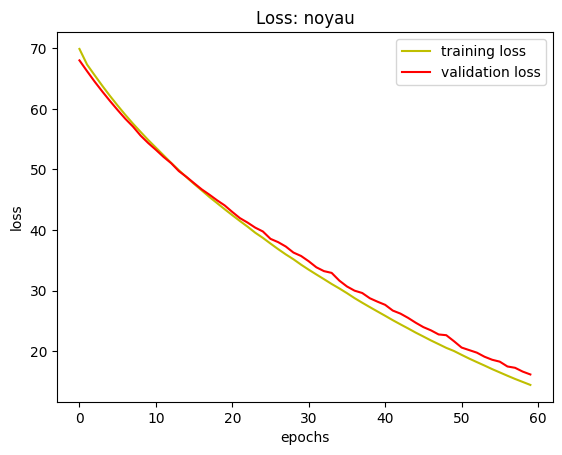

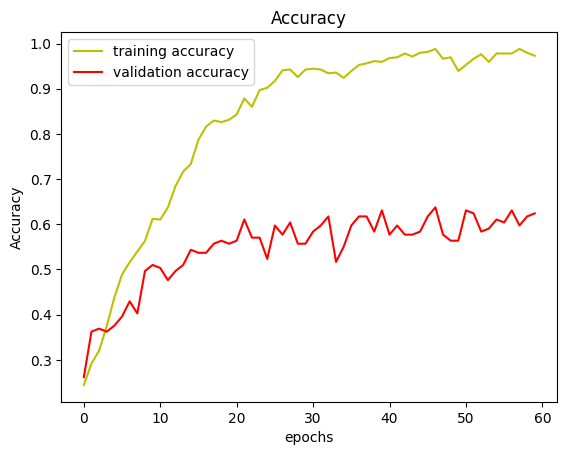

In [ ]:
plot_score(dic_res, 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 60)
plot_score(dic_res, 'sparse_categorical_accuracy','val_sparse_categorical_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 60)


##Evaluation:

3/3 [==============================] - 19s 5s/step


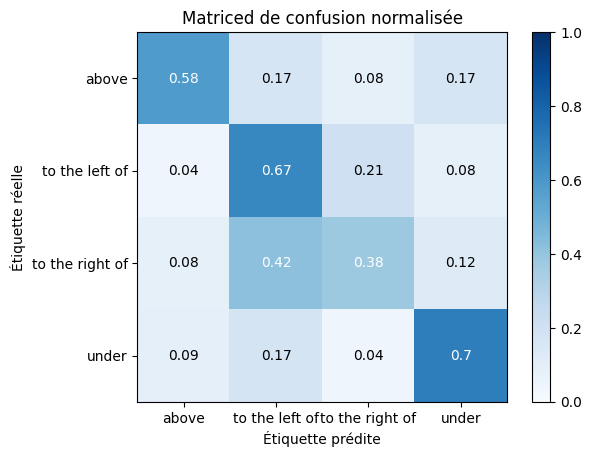

In [ ]:
# Evaluation du modele: y_pred_classes = tf.argmax( model.predict(X_test), axis=1)

noms_classes = ['above','to the left of' ,'to the right of', 'under']


Plot_matrice_confusion(Y_test, tf.argmax(Modele_classification_VGGNet_MLP.predict(X_test), axis=1), noms_classes,
                       'Matriced de confusion normalisée', cmap=plt.cm.Blues)

In [ ]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(Y_test,tf.argmax(Modele_classification_VGGNet_MLP.predict(X_test), axis=1))
print(f"Accuracy: {accuracy}")

3/3 [==============================] - 0s 136ms/step
Accuracy: 0.5789473684210527


#Modèle 3 (Image + BBox):

In [ ]:
box_c, labels = Bbox(data_SpatialSense[1].astype('uint8'), data_SpatialSense[2])


papers to the right of basket


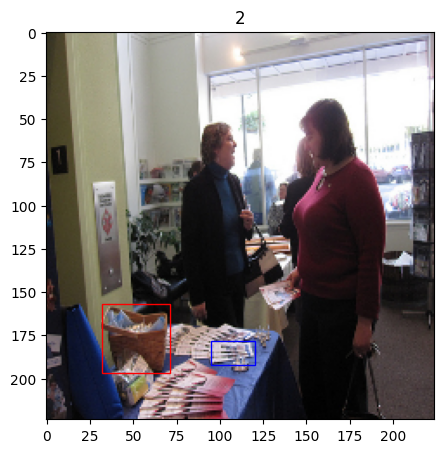

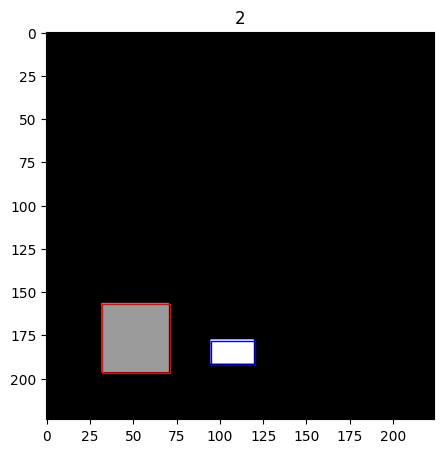

In [ ]:
n = 156
print(data_SpatialSense[3][n])

coord_ob = [ [box_c[n][1],box_c[n][0],box_c[n][5], box_c[n][4]],[box_c[n][9],box_c[n][8],box_c[n][13], box_c[n][12]] ]
#plt.imshow(data_SpatialSense[0][n])
#plt.show()
#Plot_image_bbox(Images[n], Labels[n],coord_bbox[n] )
Plot_image_bbox(data_SpatialSense[0][n], data_SpatialSense[2][n],coord_ob )
Plot_image_bbox(data_SpatialSense[1][n], data_SpatialSense[2][n],coord_ob )


In [ ]:
images_train_v, images_test, bounding_boxes_train_v, bounding_boxes_test, labels_train_v, labels_test = Split_Images_bbox(data_SpatialSense[1], box_c, labels, 0.15)
images_train, images_val, bounding_boxes_train, bounding_boxes_val, labels_train, labels_val  =Split_Images_bbox(images_train_v, bounding_boxes_train_v,labels_train_v, 0.15)


In [ ]:
print(np.unique( labels_train, return_counts= True))
print(np.unique( labels_val, return_counts= True))
print(np.unique( labels_test, return_counts= True))


(array([0, 1, 2, 3], dtype=int32), array([155, 146, 159, 156]))
(array([0, 1, 2, 3], dtype=int32), array([27, 29, 29, 24]))
(array([0, 1, 2, 3], dtype=int32), array([33, 38, 25, 33]))






## modèle 3, from scratch:

In [ ]:
# Modèle pour la classification d’images segmentées:
Modele_classification_VGGNet_MLP = Modele(4, 0)
# Modèle pour la classification des boites englobante:
Modelmlp = MLP(4)
Comb_modeles = Combine_modeles(Modele_classification_VGGNet_MLP, Modelmlp,4 )

In [ ]:
res_comb_modeles = Comb_modeles.fit([images_train,  bounding_boxes_train], labels_train,validation_data = ([images_val,  bounding_boxes_val], labels_val), epochs=50, batch_size=64)


Epoch 1/50
10/10 [==============================] - 17s 919ms/step - loss: 1.4613 - sparse_categorical_accuracy: 0.2841 - val_loss: 1.4146 - val_sparse_categorical_accuracy: 0.3486
Epoch 2/50
10/10 [==============================] - 8s 823ms/step - loss: 1.4218 - sparse_categorical_accuracy: 0.2760 - val_loss: 1.4183 - val_sparse_categorical_accuracy: 0.2936
Epoch 3/50
10/10 [==============================] - 8s 848ms/step - loss: 1.3893 - sparse_categorical_accuracy: 0.3019 - val_loss: 1.3819 - val_sparse_categorical_accuracy: 0.3670
Epoch 4/50
10/10 [==============================] - 8s 850ms/step - loss: 1.3691 - sparse_categorical_accuracy: 0.3295 - val_loss: 1.3724 - val_sparse_categorical_accuracy: 0.3578
Epoch 5/50
10/10 [==============================] - 8s 834ms/step - loss: 1.3577 - sparse_categorical_accuracy: 0.3231 - val_loss: 1.3610 - val_sparse_categorical_accuracy: 0.3761
Epoch 6/50
10/10 [==============================] - 8s 826ms/step - loss: 1.3454 - sparse_categoric

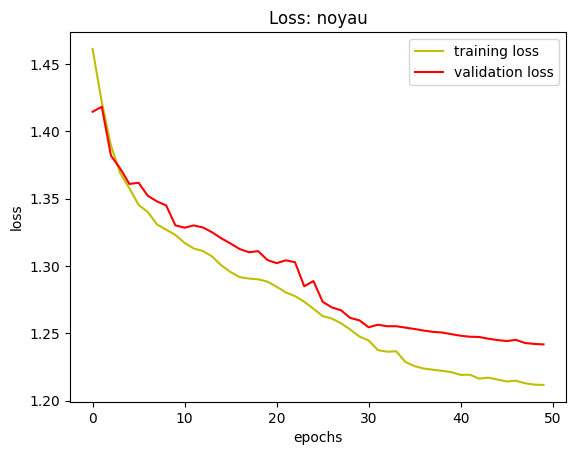

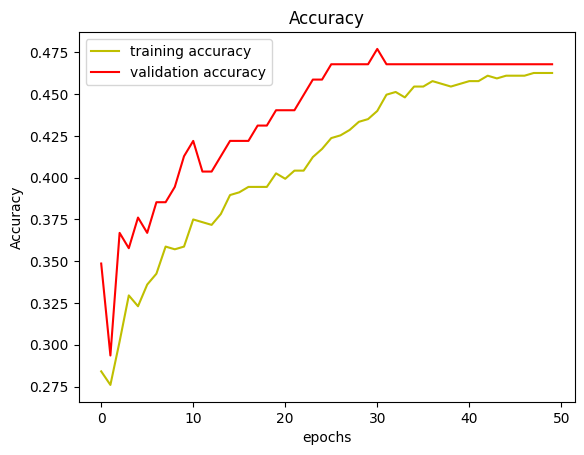

In [ ]:
plot_score(res_comb_modeles, 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 50)
plot_score(res_comb_modeles, 'sparse_categorical_accuracy','val_sparse_categorical_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 50)


5/5 [==============================] - 1s 130ms/step


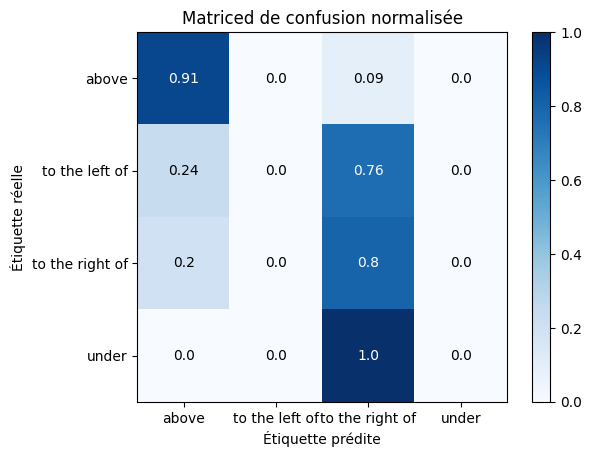

In [ ]:

noms_classes = ['above','to the left of' ,'to the right of', 'under']


Plot_matrice_confusion(labels_test, tf.argmax(Comb_modeles.predict([images_test,  bounding_boxes_test]), axis=1), noms_classes,
                       'Matriced de confusion normalisée', cmap=plt.cm.Blues)


In [ ]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(labels_test, tf.argmax(Comb_modeles.predict([images_test,  bounding_boxes_test]), axis=1))
print(f"Accuracy: {accuracy}")

5/5 [==============================] - 1s 137ms/step
Accuracy: 0.3875968992248062


## Modèle (images + Bbox): Pré-entrainement sur les données SimpleShapeset affinement du modèle  sur SpatialSense

In [ ]:
 modele_comb = chargement_modele('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/parametres_modele/Comb_modele_arch.h5')

In [ ]:
model_ft = modele_C_ft( modele_comb, 2)

In [ ]:
model_ft.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])



In [ ]:
res_app = model_ft.fit([images_train,  bounding_boxes_train], labels_train,validation_data = ([images_val,  bounding_boxes_val], labels_val), epochs=50, batch_size=8)


Epoch 1/50
77/77 [==============================] - 11s 95ms/step - loss: 1.4520 - sparse_categorical_accuracy: 0.3231 - val_loss: 1.5030 - val_sparse_categorical_accuracy: 0.2294
Epoch 2/50
77/77 [==============================] - 5s 70ms/step - loss: 1.4038 - sparse_categorical_accuracy: 0.3263 - val_loss: 1.4590 - val_sparse_categorical_accuracy: 0.2477
Epoch 3/50
77/77 [==============================] - 5s 68ms/step - loss: 1.3620 - sparse_categorical_accuracy: 0.3279 - val_loss: 1.4206 - val_sparse_categorical_accuracy: 0.2477
Epoch 4/50
77/77 [==============================] - 5s 66ms/step - loss: 1.3262 - sparse_categorical_accuracy: 0.3328 - val_loss: 1.3861 - val_sparse_categorical_accuracy: 0.2477
Epoch 5/50
77/77 [==============================] - 5s 60ms/step - loss: 1.2947 - sparse_categorical_accuracy: 0.3344 - val_loss: 1.3556 - val_sparse_categorical_accuracy: 0.2477
Epoch 6/50
77/77 [==============================] - 4s 57ms/step - loss: 1.2676 - sparse_categorical_acc

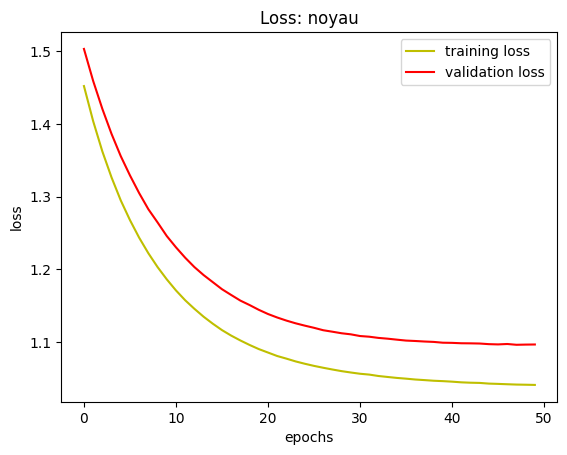

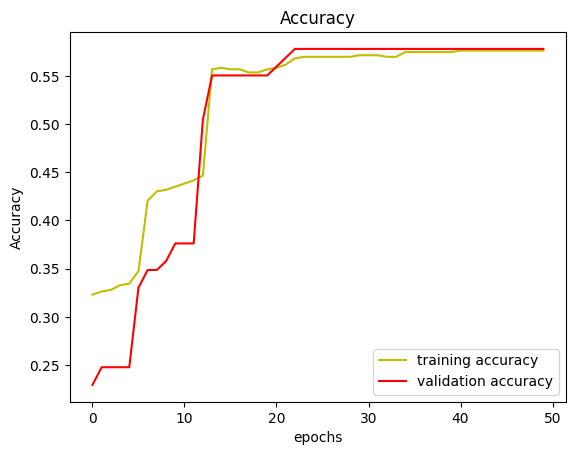

In [ ]:
plot_score(res_app, 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 50)
plot_score(res_app, 'sparse_categorical_accuracy','val_sparse_categorical_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 50)


5/5 [==============================] - 1s 130ms/step


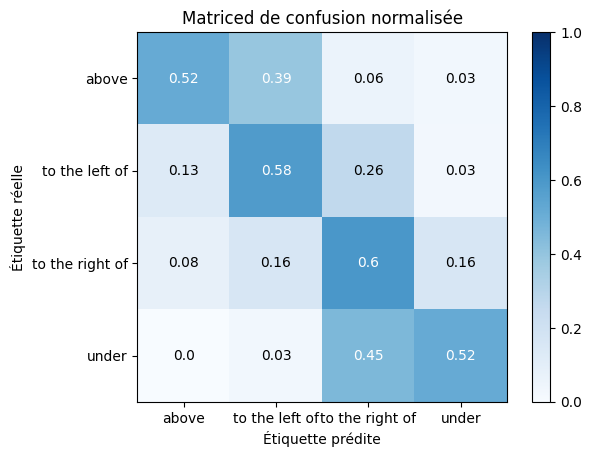

In [ ]:
noms_classes = ['above','to the left of' ,'to the right of', 'under']


Plot_matrice_confusion(labels_test, tf.argmax(model_ft.predict([images_test,  bounding_boxes_test]), axis=1), noms_classes,
                       'Matriced de confusion normalisée', cmap=plt.cm.Blues)

In [ ]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(labels_test, tf.argmax(model_ft.predict([images_test,  bounding_boxes_test]), axis=1))
print(f"Accuracy: {accuracy}")

5/5 [==============================] - 1s 126ms/step
Accuracy: 0.5503875968992248


# Extraction des representations des mots en utilisant le modele Bert:

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel, BertTokenizer
import torch
from keras.layers import Input, Concatenate, Dense
from keras.models import Model

In [ ]:

def preprocess(text):
  #tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  return  tokenizer,tokenizer(text,padding=True, truncation=True, return_tensors='pt')



In [ ]:
def embeddings(lt_imput_ids,lt_attention_mask , tokenizer):

  model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

  entrées_encod = {'input_ids': lt_imput_ids, 'attention_mask': lt_attention_mask}
  # Obtenir les sorties du modèle
  with torch.no_grad():
      outputs = model(**entrées_encod)

  # Les derniers états cachés sont les embeddings des tokens
  embeddings = outputs.last_hidden_state

  # Obtenez les représentations de mots individuels en parcourant les embeddings de tokens

  word_representations_phrases = []

  for rep_phrase in lt_imput_ids:
    word_representations_phrase = []
    for i, token in enumerate(rep_phrase):
        # Ignorez les tokens de padding (s'ils existent)
        if token != tokenizer.pad_token_id:
            word_representation = embeddings[0, i, :].numpy()  # Obtenez l'embedding du token
            word_representations_phrase.append((tokenizer.decode(token.item()), word_representation))
    word_representations_phrases.append(word_representations_phrase)

  return  word_representations_phrases#embeddings


In [ ]:
def Combine_caracteristique_text(model_comb_ima_bbox, rep_mot, num_classes):


  #sorties des deux modèles:
  output_model_CNN_comb = model_comb_ima_bbox.output

  features_text_input = Input(shape=rep_mot.shape[1:])
  print(rep_mot.shape[1:])


  # Concatenation des sorties des deux modèles:
  combined_features = Concatenate(axis=-1)([output_model_CNN_comb ,  features_text_input ])
  # Ajout de couche de classification :
  classification_layer = Dense(num_classes, activation='softmax', name = 'classification_layer_un')(combined_features)

  # creation + Compilation du modele:
  combined_model = Model(inputs=[model_comb_ima_bbox.input,   features_text_input ], outputs=classification_layer)


  return combined_model

In [ ]:
#Agréger les fonctionnalités des mots pour les phrases
def average_word_vectors(des_mots_phrases):
  l = []
  for elem in des_mots_phrases:

    # Assuming sentence_word_vectors is a list of (word, vector) tuples
    vectors = [vec for word, vec in elem]
    l.append(np.mean(vectors, axis=0))
  return np.array(l)

In [ ]:
box_c, labels = Bbox(data_SpatialSense[1].astype('uint8'), data_SpatialSense[2])

In [ ]:
print(list(data_SpatialSense[3]))

['men under tree', 'display to the left of wall', 'glass door under exit sign', 'leaf to the right of olive', 'picture above bicycle', 'man to the left of man', 'tiger to the left of woman', 'train to the left of advertisement board', 'smoke above lawn', 'man under window', 'person under window', 'trophy above shoe', 'table under books', 'cell phone above computer screen', 'bottle to the right of balloon', 'christmas light to the right of window', 'sticker above jeans', 'bass to the left of man', 'book to the right of man', 'kitten to the left of tire', 'women to the left of men', 'water under bridge', 'man to the left of other man', 'earth under tree', 'rug to the right of frame', 'smoke above grass', 'pancake above banana', 'window decal to the right of pet', 'cabinet to the left of air conditioner', 'fan under picture', 'green bottle to the right of red bottle', 'chair to the right of chair', 'dog under chocolate', 'pipe under window', 'bird to the right of person', 'window above co

In [ ]:
# pré-processing:
tokenizer , encod_text = preprocess(list(data_SpatialSense[3]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
l_imput_ids = encod_text['input_ids']
l_attention_mask = encod_text['attention_mask']
print(len(encod_text['input_ids']))
print(len(l_attention_mask))

472
472


In [ ]:
print(np.array(l_attention_mask).shape)

(38, 10)


In [ ]:
images_train_v, images_test, bounding_boxes_train_v, bounding_boxes_test, labels_train_v, labels_test, imput_id_train_v, imput_id_test, attention_mask_train_v, attention_mask_tes, text_train_v, text_test=train_test_split(data_SpatialSense[1], box_c, labels, l_imput_ids,l_attention_mask,data_SpatialSense[3] , test_size=0.1, random_state=42)
images_train, images_validation, bounding_boxes_train, bounding_boxes_validation, labels_train, labels_validation, imput_id_train,imput_id_validation, attention_mask_train, attention_mask_validation, text_train, text_validation=train_test_split(images_train_v,  bounding_boxes_train_v,  labels_train_v  ,  imput_id_train_v, attention_mask_train_v,text_train_v, test_size=0.1, random_state=42)


In [ ]:
Representation_mots_train = embeddings(imput_id_train,attention_mask_train,tokenizer)
Representation_mots_val = embeddings(imput_id_validation,attention_mask_validation,tokenizer)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
print(text_train[2])
for word, representation in Representation_mots_train[2]:
    print(f"Mot: {word}")#, Représentation: {representation}")

kitten to the left of tire
Mot: [ C L S ]
Mot: k i t t e n
Mot: t o
Mot: t h e
Mot: l e f t
Mot: o f
Mot: t i r e
Mot: [ S E P ]


In [ ]:
Agregation_mots_phrase = average_word_vectors(Representation_mots_train)
print(type(Agregation_mots_phrase))
tensor_Agregation_mots_phrase_train= tf.convert_to_tensor(Agregation_mots_phrase , dtype=tf.float32)

<class 'numpy.ndarray'>


In [ ]:
Agregation_mots_phrase_val = average_word_vectors(Representation_mots_val)

tensor_Agregation_mots_phrase_val= tf.convert_to_tensor(Agregation_mots_phrase_val , dtype=tf.float32)

In [ ]:
modele_comb = chargement_modele('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/parametres_modele/Comb_modele_arch.h5')
model_ft = modele_C_ft( modele_comb, 4)
Modele_combine_cnn_nlp = Combine_caracteristique_text(model_ft , tensor_Agregation_mots_phrase_train , 4)

(768,)


In [ ]:
Modele_combine_cnn_nlp.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

In [ ]:
res_app = Modele_combine_cnn_nlp.fit([[images_train,  bounding_boxes_train],tensor_Agregation_mots_phrase_train] ,
        labels_train,validation_data = ([[images_validation,  bounding_boxes_validation],tensor_Agregation_mots_phrase_val], labels_validation), epochs=50, batch_size=8)


Epoch 1/50
48/48 [==============================] - 19s 231ms/step - loss: 1.6611 - accuracy: 0.2546 - val_loss: 1.6762 - val_accuracy: 0.1860
Epoch 2/50
48/48 [==============================] - 3s 54ms/step - loss: 1.5423 - accuracy: 0.2546 - val_loss: 1.5791 - val_accuracy: 0.1860
Epoch 3/50
48/48 [==============================] - 3s 57ms/step - loss: 1.4662 - accuracy: 0.2546 - val_loss: 1.5181 - val_accuracy: 0.1860
Epoch 4/50
48/48 [==============================] - 3s 60ms/step - loss: 1.4182 - accuracy: 0.2546 - val_loss: 1.4734 - val_accuracy: 0.1860
Epoch 5/50
48/48 [==============================] - 3s 58ms/step - loss: 1.3864 - accuracy: 0.2546 - val_loss: 1.4491 - val_accuracy: 0.1860
Epoch 6/50
48/48 [==============================] - 3s 58ms/step - loss: 1.3640 - accuracy: 0.2546 - val_loss: 1.4314 - val_accuracy: 0.1860
Epoch 7/50
48/48 [==============================] - 2s 50ms/step - loss: 1.3487 - accuracy: 0.2651 - val_loss: 1.4202 - val_accuracy: 0.1860
Epoch 8/50


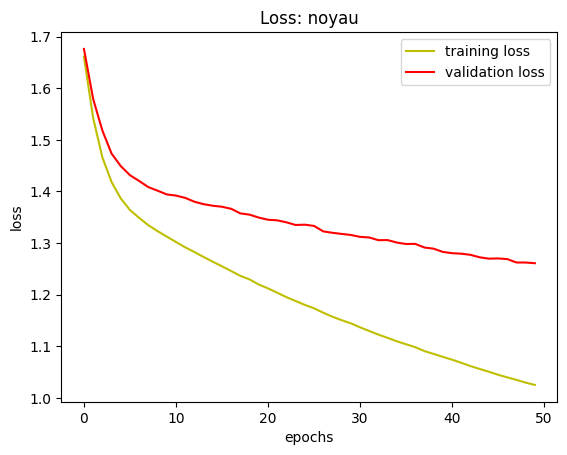

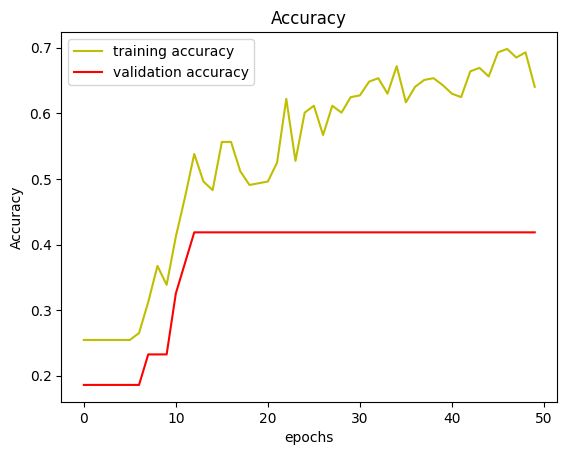

In [ ]:
plot_score(res_app, 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 50)
plot_score(res_app, 'accuracy','val_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 50)

In [ ]:
Representation_mots_test = embeddings(imput_id_test,attention_mask_tes,tokenizer)
Agregation_mots_phrase_test = average_word_vectors(Representation_mots_test)

tensor_Agregation_mots_phrase_test= tf.convert_to_tensor(Agregation_mots_phrase_test , dtype=tf.float32)

2/2 [==============================] - 0s 182ms/step


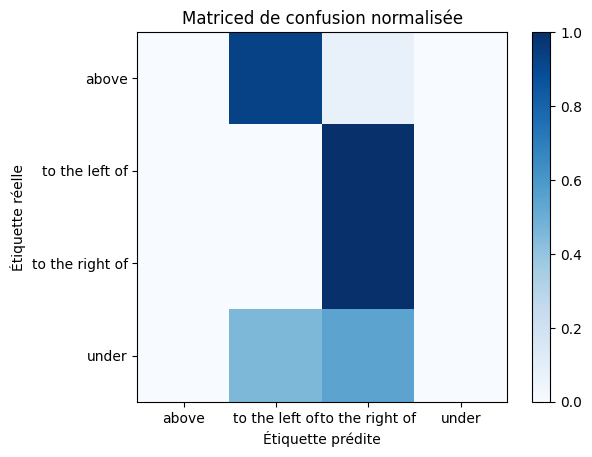

In [ ]:
noms_classes = ['above','to the left of' ,'to the right of', 'under']


Plot_matrice_confusion(labels_test,tf.argmax( Modele_combine_cnn_nlp.predict([[images_test,  bounding_boxes_test],tensor_Agregation_mots_phrase_test]), axis=1)
,noms_classes,     'Matriced de confusion normalisée', cmap=plt.cm.Blues)